Entrenando la arquitectura VGG-16

Keras tiene a nuestra disposición tanto la arquitectura VGG-16 como la VGG-19. Vamos a entrenar ambas y una más que explicaremos en breve. Debido a que vamos a usar la definida en Keras (aunque podríamos crearla directamente), debemos aumentar el tamaño de las imágenes a 48 píxeles. Para ello, usaremos el siguiente código:

Importando Librerías

In [1]:
import numpy as np
from scipy import misc
from PIL import Image
import glob
import matplotlib.pyplot as plt
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from IPython.display import SVG
import cv2
import seaborn as sn
import pandas as pd
import pickle
from keras import layers
from keras.layers import Flatten, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Sequential, Model, load_model
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import layer_utils, np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.initializers import glorot_uniform
from keras import losses
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

Preparando el conjunto de datos
Como antes, usaremos el conjunto de datos CIFAR-100, que, como ya dijimos, consta de 600 imágenes por cada clase de un total de 100 clases. Se divide en 500 imágenes para entrenamiento y 100 imágenes para validación por cada clase. Las 100 clases están agrupadas en 20 superclases. Cada imagen tiene una etiqueta "fina" (la clase, de entre las 100, a la que pertenece) y una etiqueta "gruesa" (correspondiente a su superclase).

In [2]:
from keras.datasets import cifar100

(x_train_original, y_train_original), (x_test_original, y_test_original) = cifar100.load_data(label_mode='fine')

Actualmente, hemos descargado los datasets de entrenamiento y validación. x_train_original y x_test_original son los conjuntos de datos con lás imágenes de entrenamiento y validación respectivamente, mientras que y_train_original y y_test_original son los datasets con las etiquetas.

Veamos la forma de y_train_original:
    array([[19], [29], [ 0], ..., [ 3], [ 7], [73]])  
    
Como se puede ver, se trata de un array donde cada número se corresponde con la etiqueta concreta. Lo primero que hay que hacer es convertir este array en su versión one-hot-encoding    

In [3]:
y_train = np_utils.to_categorical(y_train_original, 100)
y_test = np_utils.to_categorical(y_test_original, 100)

Bien, representa la imagen en los 3 canales RGB de 256 píxeles. Vamos a verla:

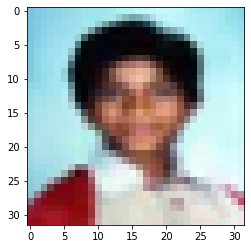

In [4]:
imgplot = plt.imshow(x_train_original[3])
plt.show()

Lo que haremos a continuación, es normalizar las imágenes. Esto es, dividiremos cada elemento de x_train_original y xtestoriginal por el numero de píxeles, es decir, 255. Con esto obtenemos que el array comprenderá valores de entre 0 y 1. Con esto el entrenamiento suele aportar mejores resultados.

In [5]:
x_train = x_train_original/255  
x_test = x_test_original/255  

Preparando el entorno
El siguiente paso es definir ciertos parámetros sobre el experimento en Keras. Lo primero será especificar a Keras dónde se encuentran los canales. En un array de imágenes, pueden venir como último indice o como el primero. Esto se conoce como canales primero (channels first) o canales al final (channels last). En nuestro caso, vamos a definirlos al final.

In [6]:
K.set_image_data_format('channels_last')  

Lo siguiente que vamos a especificar es la fase del experimento. En este caso, la fase será de entrenamiento:

In [7]:
K.set_learning_phase(True)  

C:\Users\INVITADO_0310\anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [8]:
x_train_original[0]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [195, 205, 193],
        [212, 224, 204],
        [182, 194, 167]],

       [[255, 255, 255],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [170, 176, 150],
        [161, 168, 130],
        [146, 154, 113]],

       [[255, 255, 255],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [189, 199, 169],
        [166, 178, 130],
        [121, 133,  87]],

       ...,

       [[148, 185,  79],
        [142, 182,  57],
        [140, 179,  60],
        ...,
        [ 30,  17,   1],
        [ 65,  62,  15],
        [ 76,  77,  20]],

       [[122, 157,  66],
        [120, 155,  58],
        [126, 160,  71],
        ...,
        [ 22,  16,   3],
        [ 97, 112,  56],
        [141, 161,  87]],

       [[ 87, 122,  41],
        [ 88, 122,  39],
        [101, 134,  56],
        ...,
        [ 34,  36,  10],
        [105, 133,  59],
        [138, 173,  79]]

Entrenando una red neuronal VGG
En primer lugar, vamos a entrenar una red neuronal sencilla. Definimos un procedimiento que nos devuelva una red neuronal:

In [9]:
def resize_data(data):  
    data_upscaled = np.zeros((data.shape[0], 48, 48, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(48, 48), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

x_train_resized = resize_data(x_train_original)  
x_test_resized = resize_data(x_test_original)  
x_train_resized = x_train_resized / 255  
x_test_resized = x_test_resized / 255  

Con esto, tenemos las imágenes a 48 píxeles normalizadas en x_train_resized y x_test_resized. Como dijimos antes, entrenaremos los modelos VGG-16, VGG-19 y uno más. Esta es nuestra propia versión de VGG con objeto de no tener que modificar el tamaño de las imágenes. Empezaremos entrenando VGG-16, veremos resultados y continuaremos con VGG-19 para terminar con nuestra Custom VGG.

VGG-16
Definimos el modelo. Tan fácil como llamar al existente en Keras:

In [10]:
from keras.applications import vgg16

def create_vgg16():  
  model = vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=(48,48,3), pooling=None, classes=100)

  return model

Los parámetros son sencillos: vamos a incluir una red neuronal densa al final con el parámetro include_top. No cargamos ningún modelo entrenado a priori con el parámetro weights. No especificamos ningún tensor de keras como entrada con input_tensor. Definimos la forma de los datos de entrada con input_shape, No especificamos Pooling final con pooling y definimos el número de clases final con classes.

Una vez definido el modelo, lo compilamos especificando la función de optimización, la de coste o pérdida y las métricas que usaremos. En este caso, como en los artículos anteriores, usaremos la función de optimización stochactic gradient descent, la función de pérdida categorical cross entropy y, para las métricas, accuracy y mse (media de los errores cuadráticos).

In [11]:
vgg16_model = create_vgg16()  
vgg16_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])  

Una vez hecho esto, vamos a ver un resumen del modelo creado:

In [12]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

Ahora el número de parámetros ha crecido sustancialmente (34 millones). Ahora sólo queda entrenar:

In [13]:
vgg16 = vgg16_model.fit(x=x_train_resized, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test_resized, y_test), shuffle=True)  

Epoch 1/10
   9/1563 [..............................] - ETA: 24:26 - loss: 4.6052 - acc: 0.0104 - mse: 0.0099

KeyboardInterrupt: 

Obviaremos la evaluación.

Veamos las métricas obtenidas para el entrenamiento y validación gráficamente:

In [ ]:
plt.figure(0)  
plt.plot(vgg16.history['acc'],'r')  
plt.plot(vgg16.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(vgg16.history['loss'],'r')  
plt.plot(vgg16.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

La generalización mejora a un 1% aproximadamente respecto a la red convolucional del experimento anterior, si bien, después de 10 epochs no ha mejorado las métricas estándar.

Matriz de confusión
Pasemos ahora a ver la matriz de confusión y las métricas de Accuracy, Recall y F1-score.

Vamos a hacer una predicción sobre el dataset de validación y, a partir de ésta, generamos la matriz de confusión y mostramos las métricas mencionadas anteriormente:

In [ ]:
vgg16_pred = vgg16_model.predict(x_test_resized, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16_pred, axis=1)  

In [ ]:
Vamos a dar como predicha el mayor valor de la predicción. Lo normal es dar un valor mínimo o bias que defina un resultado como positivo, pero en este caso, lo vamos a hacer simple.

Con la librería Scikit Learn, generamos la matriz de confusión y la dibujamos (aunque el gráfico no es muy bueno debido al numero de etiquetas).

In [ ]:
#Creamos la matriz de confusión
vgg16_cm = confusion_matrix(np.argmax(y_test, axis=1), vgg16_predicted)

# Visualiamos la matriz de confusión
vgg16_df_cm = pd.DataFrame(vgg16_cm, range(100), range(100))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg16_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

Y por último, mostramos las métricas:

In [ ]:
vgg16_report = classification_report(np.argmax(y_test, axis=1), vgg16_predicted)  
print(vgg16_report)

Curva ROC (tasas de verdaderos positivos y falsos positivos)
Vamos a codificar la curva ROC para clasificación multiclase. 

In [ ]:
from sklearn.datasets import make_classification  
from sklearn.preprocessing import label_binarize  
from scipy import interp  
from itertools import cycle

n_classes = 100

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()  
tpr = dict()  
roc_auc = dict()  
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], vgg16_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), vgg16_pred.ravel())  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)  
for i in range(n_classes):  
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr  
tpr["macro"] = mean_tpr  
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(n_classes-97), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)  
plt.xlim(0, 0.2)  
plt.ylim(0.8, 1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(3), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()  

Vamos a ver algunos resultados:

In [ ]:
imgplot = plt.imshow(x_train_original[0])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[0])))  
print('predicted:         ' + str(vgg16_predicted[0]))  

In [ ]:
imgplot = plt.imshow(x_train_original[3])  
plt.show()  
print('class for image 3: ' + str(np.argmax(y_test[3])))  
print('predicted:         ' + str(vgg16_predicted[3]))  

Salvaremos los datos del histórico de entrenamiento para compararlos con otros modelos:

In [ ]:
#Histórico
with open(path_base + '/vgg16_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

VGG-19
Definamos el modelo y entrenemos de la misma forma que VGG-16.

In [ ]:
def create_vgg19():  
  model = vgg19.VGG19(include_top=True, weights=None, input_tensor=None, input_shape=(48,48,3), pooling=None, classes=100)

  return model

vgg19_model = create_vgg19()  
vgg19_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])  

Una vez hecho esto, vamos a ver un resumen del modelo creado.

In [ ]:
vgg19_model.summary()

Ahora sólo queda entrenar.

In [ ]:
vgg19 = vgg19_model.fit(x=x_train_resized, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test_resized, y_test), shuffle=True)  

Obviaremos la evaluación.

Veamos las métricas obtenidas para el entrenamiento y validación gráficamente.

In [ ]:
plt.figure(0)  
plt.plot(vgg19.history['acc'],'r')  
plt.plot(vgg19.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(vgg19.history['loss'],'r')  
plt.plot(vgg19.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

Matriz de confusión
Pasemos ahora a ver la matriz de confusión y las métricas de Accuracy, Recall y F1-score.

Vamos a hacer una predicción sobre el dataset de validación y, a partir de ésta, generamos la matriz de confusión y mostramos las métricas mencionadas anteriormente.

In [ ]:
vgg19_pred = vgg19_model.predict(x_test_resized, batch_size=32, verbose=1)  
vgg19_predicted = np.argmax(vgg19_pred, axis=1)  

vamos a dar como predicción el mayor valor. Lo normal es dar un valor mínimo o bias que defina un resultado como positivo, pero en este caso, lo vamos a hacer simple.

Con la librería Scikit Learn, generamos la matriz de confusión y la dibujamos (aunque el gráfico no es muy bueno debido al numero de etiquetas).

In [ ]:
#Creamos la matriz de confusión
vgg19_cm = confusion_matrix(np.argmax(y_test, axis=1), vgg19_predicted)

# Visualiamos la matriz de confusión
vgg19_df_cm = pd.DataFrame(vgg19_cm, range(100), range(100))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg19_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

Y por último, mostramos las métricas:

In [ ]:
vgg19_report = classification_report(np.argmax(y_test, axis=1), vgg19_predicted)  
print(vgg19_report)

Curva ROC (tasas de verdaderos positivos y falsos positivos)
Vamos a codificar la curva ROC:

In [ ]:
from sklearn.datasets import make_classification  
from sklearn.preprocessing import label_binarize  
from scipy import interp  
from itertools import cycle

n_classes = 100

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()  
tpr = dict()  
roc_auc = dict()  
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], vgg19_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), vgg19_pred.ravel())  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)  
for i in range(n_classes):  
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr  
tpr["macro"] = mean_tpr  
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(n_classes-97), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)  
plt.xlim(0, 0.2)  
plt.ylim(0.8, 1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(3), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()  

Vamos a ver algunos resultados:

In [ ]:
imgplot = plt.imshow(x_train_original[0])  
plt.show()  
print('class for image 1: ' + str(np.argmax(y_test[0])))  
print('predicted:         ' + str(vgg19_predicted[0]))  

In [ ]:
imgplot = plt.imshow(x_train_original[3])  
plt.show()  
print('class for image 3: ' + str(np.argmax(y_test[3])))  
print('predicted:         ' + str(vgg19_predicted[3]))  

Salvaremos los datos del histórico de entrenamiento para compararlos con otros modelos:

In [ ]:
#Histórico
with open('vgg19_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

A continuación, cargaremos las métricas obtenidas de anteriores modelos y los comparamos con los resultados actuales:

In [ ]:
with open('vgg16_history.txt', 'rb') as f:  
  vgg16_history = pickle.load(f)

Ya lo tenemos en las variables correspondientes. Ahora, comparemos las gráficas:

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_acc'],'r')  
plt.plot(scnn_history['val_acc'],'g')  
plt.plot(vgg16_history['val_acc'],'b')  
plt.plot(vgg19.history['val_acc'],'y')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Simple NN Accuracy vs simple CNN Accuracy")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19'])  

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_loss'],'r')  
plt.plot(scnn_history['val_loss'],'g')  
plt.plot(vgg16.history['val_loss'],'b')  
plt.plot(vgg19.history['val_loss'],'y')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Simple NN Loss vs simple CNN Loss")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19'])  

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_mean_squared_error'],'r')  
plt.plot(scnn_history['val_mean_squared_error'],'g')  
plt.plot(vgg16.history['val_mean_squared_error'],'b')  
plt.plot(vgg19.history['val_mean_squared_error'],'y')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Mean Squared Error")  
plt.title("Simple NN MSE vs simple CNN MSE")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19'])  

¿Qué ha pasado?
Bien, la respuesta es sencilla. Hemos querido usar un modelo predeterminado, obligándonos a modificar la imagen original haciéndola más grande. Como la imagen es de 32x32 píxeles, pues la imagen resultante queda peor y aprende peor. Esto es, hemos cambiado el ámbito de los datos con respecto a los experimentos anteriores.

Así que lo que tenemos que hacer, es una red VGG que no necesite modificar la imagen original.

Custom VGG
Definamos el modelo más específicamente:

In [ ]:
def VGG16_Without_lastPool(include_top=True, input_tensor=None, input_shape=(32,32,3), pooling=None, classes=100):  
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)  #to 16x16

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x) #to 8x8

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x) #to 4x4

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x) #to 2x2

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    #x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)


    # Create model.
    model = Model(img_input, x, name='vgg16Bis')

    return model

Compilamos como hasta ahora...

In [ ]:
def create_vgg16WithoutPool():  
  model = VGG16_Without_lastPool(include_top=True, input_tensor=None, input_shape=(32,32,3), pooling=None, classes=100)

  return model

vgg16Bis_model = create_vgg16WithoutPool()  
vgg16Bis_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc', 'mse'])  

Una vez hecho esto, vamos a ver un resumen del modelo creado:

In [ ]:
vgg16Bis_model.summary()

Tenemos uno más, 40 millones de parámetros, porque en realidad, sólo hemos quitado el Pool del bloque 5. Ahora sólo queda entrenar, pero esta vez con el dataset original normalizado:

In [ ]:
vgg16Bis = vgg16Bis_model.fit(x=x_train, y=y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test), shuffle=True)  

Veamos las métricas obtenidas para el entrenamiento y validación gráficamente:

In [ ]:
plt.figure(0)  
plt.plot(vgg16Bis.history['acc'],'r')  
plt.plot(vgg16Bis.history['val_acc'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(vgg16Bis.history['loss'],'r')  
plt.plot(vgg16Bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show()  

Matriz de confusión
Pasemos ahora a ver la matriz de confusión y las métricas de Accuracy, Recall y F1-score.

Vamos a hacer una predicción sobre el dataset de validación y, a partir de ésta, generamos la matriz de confusión y mostramos las métricas mencionadas anteriormente:

In [ ]:
vgg16Bis_pred = vgg16Bis_model.predict(x_test, batch_size=32, verbose=1)  
vgg16Bis_predicted = np.argmax(vgg16Bis_pred, axis=1)

vgg_cm = confusion_matrix(np.argmax(y_test, axis=1), vgg16Bis_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(100), range(100))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show()  

Y por último, mostramos las métricas:

In [ ]:
vgg_report = classification_report(np.argmax(y_test, axis=1), vgg16Bis_predicted)  
print(vgg_report)

In [ ]:
Curva ROC (tasas de verdaderos positivos y falsos positivos)
Vamos a codificar de nuevo la curva ROC:

In [ ]:
from sklearn.datasets import make_classification  
from sklearn.preprocessing import label_binarize  
from scipy import interp  
from itertools import cycle

n_classes = 100

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()  
tpr = dict()  
roc_auc = dict()  
for i in range(n_classes):  
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], vgg16Bis_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), vgg16Bis_pred.ravel())  
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)  
for i in range(n_classes):  
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr  
tpr["macro"] = mean_tpr  
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(n_classes-97), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.05])  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)  
plt.xlim(0, 0.2)  
plt.ylim(0.8, 1)  
plt.plot(fpr["micro"], tpr["micro"],  
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],  
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])  
for i, color in zip(range(3), colors):  
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  
plt.title('Some extension of Receiver operating characteristic to multi-class')  
plt.legend(loc="lower right")  
plt.show()  

Salvaremos los datos del histórico de entrenamiento para compararlos con otros modelos:

In [ ]:
#Histórico
with open('cvgg16_history.txt', 'wb') as file_pi:  
  pickle.dump(scnn.history, file_pi)

A continuación, vamos a comparar las métricas con los modelos anteriores:

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_acc'],'r')  
plt.plot(scnn_history['val_acc'],'g')  
plt.plot(vgg16.history['val_acc'],'b')  
plt.plot(vgg19.history['val_acc'],'y')  
plt.plot(vgg16Bis.history['val_acc'],'m')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Simple NN Accuracy vs simple CNN Accuracy")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19','Custom VGG'])  

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_loss'],'r')  
plt.plot(scnn_history['val_loss'],'g')  
plt.plot(vgg16.history['val_loss'],'b')  
plt.plot(vgg19.history['val_loss'],'y')  
plt.plot(vgg16Bis.history['val_loss'],'m')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Simple NN Loss vs simple CNN Loss")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19','Custom VGG'])  

In [ ]:
plt.figure(0)  
plt.plot(snn_history['val_mean_squared_error'],'r')  
plt.plot(scnn_history['val_mean_squared_error'],'g')  
plt.plot(vgg16.history['val_mean_squared_error'],'b')  
plt.plot(vgg19.history['val_mean_squared_error'],'y')  
plt.plot(vgg16Bis.history['val_mean_squared_error'],'m')  
plt.xticks(np.arange(0, 11, 2.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Mean Squared Error")  
plt.title("Simple NN MSE vs simple CNN MSE")  
plt.legend(['simple NN','CNN','VGG 16','VGG 19','Custom VGG'])  

Conclusión sobre el segundo Trabajo Realizado
Hemos visto unos modelos más profundos, en los que el número de parámetros ha aumentado en exceso incluso para una red convolutiva. Además, el aprendizaje es mucho más lento en este caso específico. Quizás, a la vista de los resultados, sería planteable aumentar el número de epochs a realizar, pero en cambio, sabemos que actualmente existen modelos mejores que vamos a ver.